### Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, AUC,Recall
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet121
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory


In [ ]:
!pip install git+https://github.com/jfilter/split-folders.git


  Cloning https://github.com/jfilter/split-folders.git to /tmp/pip-req-build-l6nphi5o
  Running command git clone --filter=blob:none --quiet https://github.com/jfilter/split-folders.git /tmp/pip-req-build-l6nphi5o
  Resolved https://github.com/jfilter/split-folders.git to commit c566dbd56a1097e1ddba2de5dfb93bd67eade54f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for split-folders: filename=split_folders-0.5.1-py3-none-any.whl size=8394 sha256=c446c34418b9a2f848aec039aa6df18c12274b0c3582f3996c6f5321d20d8df0
  Stored in directory: /tmp/pip-ephem-wheel-cache-xap4izr7/wheels/ea/fe/2b/dd59f73bbba9e760bf0e44a6c14042b51a572cadcd500b151e
Successfully built split-folders


In [ ]:
import splitfolders

# Set the path of the directory containing the original images
input_folder = '/kaggle/input/alzheimer-mri-dataset/Dataset'

# Set the base directory for the split images
output_folder = '/kaggle/working/Splitted'

# Set the ratio of images for each split
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

# Use the splitfolders library to split the images into train-validation-test sets
splitfolders.ratio(input_folder, output_folder, seed=42,
                   ratio=(train_ratio,
                          validation_ratio,
                          test_ratio))


Copying files: 6400 files [00:27, 230.67 files/s]


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
IMG_SIZE = (128, 128)
SEED = 1345

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        )
       
validation_datagen = ImageDataGenerator(rescale=1./255)


test_datagen = ImageDataGenerator(rescale=1./255)

# Define directories for train, validation, and test sets
train_dir = '/kaggle/working/Splitted/train'
validation_dir = '/kaggle/working/Splitted/val'
test_dir = '/kaggle/working/Splitted/test'

# Define generators for train and validation sets using flow_from_directory
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size=64,
        class_mode ='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        seed = SEED,
        shuffle=True,
        batch_size=64,
        class_mode ='categorical')

# Define generator for test set using flow_from_directory
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size =64,
        class_mode ='categorical')

epochs = 10

Found 3839 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Found 1282 images belonging to 4 classes.


In [ ]:
# class_names = train_generator.class_names
# class_names

class_names = list(train_generator.class_indices.keys())
class_names



['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

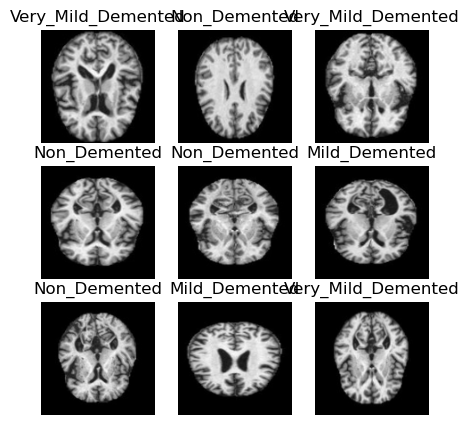

In [ ]:
plt.figure(figsize=(5, 5))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break


## Data Augmentation

In [ ]:
#preprocessing for rotation and zoom
def data_augmentar():
   
    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))
    
    return data_augmentation

In [ ]:
data_augmentation = data_augmentar()
assert(data_augmentation.layers[0].name.startswith('random_rotation'))
assert(data_augmentation.layers[0].factor == (-0.15, 0.15))
assert(data_augmentation.layers[1].name.startswith('random_zoom'))
assert(data_augmentation.layers[1].height_factor == (-0.3, -0.1))

## Solving Imbalanced Data Problem

In [ ]:
## Calculate number of samples in each class.
input_folder = '/kaggle/input/alzheimer-mri-dataset/Dataset'
class_counts = dict()
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

class_counts

{'Mild_Demented': 896,
 'Moderate_Demented': 64,
 'Non_Demented': 3200,
 'Very_Mild_Demented': 2240}

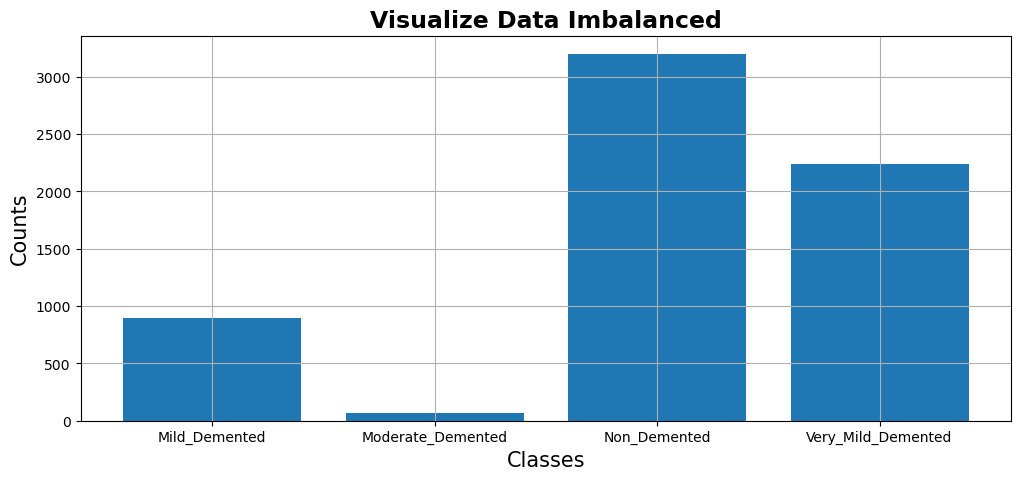

In [ ]:
plt.figure(figsize=(12,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes', fontdict={'fontsize':15})
plt.ylabel('Counts', fontdict={'fontsize':15})
plt.title('Visualize Data Imbalanced', fontdict={'fontsize':17,
                                                 'fontweight':'bold'})
plt.grid(True)
plt.show()

In [ ]:
# Class_weight = (Total Number of images/Number of class x Images per class )

total = sum(class_counts.values())
number_of_classes = len([ 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented'])

class_weights = dict()
for i in range(number_of_classes):
    class_weights[i] = round(total / (number_of_classes * list(class_counts.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weights[i]}')

Weight for class "Mild_Demented" : 1.79
Weight for class "Moderate_Demented" : 25.0
Weight for class "Non_Demented" : 0.5
Weight for class "Very_Mild_Demented" : 0.71


In [ ]:
models=[]
acc=[]

### **VGG19**

In [ ]:
base_model_3 = VGG19(input_shape=(128,128,3), 
                         include_top=False,
                         weights="imagenet")
for layer in base_model_3.layers:
  layer.trainable= False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = keras.layers.Dense(4,activation='softmax')

model3 = tf.keras.Sequential([base_model_3, global_average_layer,
  keras.layers.BatchNormalization(),  
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  prediction_layer
])


In [ ]:

model3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


# Train your model with mixed precision
history = model3.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs = epochs,
                    verbose=1)

Epoch 1/10
60/60 [==============================] - 35s 451ms/step - loss: 0.9486 - accuracy: 0.5444 - auc_1: 0.8277 - precision_1: 0.6271 - recall_1: 0.3829 - val_loss: 1.0848 - val_accuracy: 0.4472 - val_auc_1: 0.7964 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/10
60/60 [==============================] - 22s 374ms/step - loss: 0.8579 - accuracy: 0.5994 - auc_1: 0.8623 - precision_1: 0.6747 - recall_1: 0.4608 - val_loss: 1.0071 - val_accuracy: 0.5567 - val_auc_1: 0.8340 - val_precision_1: 0.8529 - val_recall_1: 0.1360
Epoch 3/10
60/60 [==============================] - 22s 374ms/step - loss: 0.7902 - accuracy: 0.6424 - auc_1: 0.8842 - precision_1: 0.7096 - recall_1: 0.5379 - val_loss: 0.9606 - val_accuracy: 0.5895 - val_auc_1: 0.8526 - val_precision_1: 0.8134 - val_recall_1: 0.2181
Epoch 4/10
60/60 [==============================] - 22s 372ms/step - loss: 0.7410 - accuracy: 0.6590 - auc_1: 0.8971 - precision_1: 0.7074 - recall_1: 0.5736 - val_loss: 0.8568 - val_ac

In [ ]:
models.append("VGG 19")
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_21 (Dense)            (None, 2048)              1050624   
                                                                 
 dense_22 (Dense)            (None, 512)               1049088   
                                                                 
 dense_23 (Dense)            (None, 256)              

In [ ]:
result = model3.evaluate(train_generator)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')

train_generator

60/60 [==============================] - 20s 330ms/step - loss: 0.3966 - accuracy: 0.8458 - auc_1: 0.9731 - precision_1: 0.8708 - recall_1: 0.8096
Train Loss = 0.39655324816703796
Train Accuracy = 0.8457931876182556
Train AUC = 0.9730572700500488
Train Precision = 0.8708321452140808
Train Recall = 0.8095858097076416


In [ ]:
filepath = './Vgg_best_weights.hdf5'
# Stop the model when accuracy is not improving
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)
# Finding point where accuracy differs more
checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
history3=model3.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator)//32,
                        epochs = 40,callbacks = callback_list,
                        verbose = 1,batch_size=32)

Epoch 1/40
1/1 [==============================] - ETA: 0s - loss: 0.6221 - accuracy: 0.7344 - auc_1: 0.9363 - precision_1: 0.7500 - recall_1: 0.7031
Epoch 1: val_accuracy improved from -inf to 0.80532, saving model to ./Vgg_best_weights.hdf5
1/1 [==============================] - 3s 3s/step - loss: 0.6221 - accuracy: 0.7344 - auc_1: 0.9363 - precision_1: 0.7500 - recall_1: 0.7031 - val_loss: 0.4774 - val_accuracy: 0.8053 - val_auc_1: 0.9591 - val_precision_1: 0.8294 - val_recall_1: 0.7717
Epoch 2/40
1/1 [==============================] - ETA: 0s - loss: 0.3979 - accuracy: 0.8125 - auc_1: 0.9704 - precision_1: 0.8361 - recall_1: 0.7969
Epoch 2: val_accuracy did not improve from 0.80532
1/1 [==============================] - 3s 3s/step - loss: 0.3979 - accuracy: 0.8125 - auc_1: 0.9704 - precision_1: 0.8361 - recall_1: 0.7969 - val_loss: 0.4905 - val_accuracy: 0.8053 - val_auc_1: 0.9571 - val_precision_1: 0.8315 - val_recall_1: 0.7717
Epoch 3/40
1/1 [==============================] - ETA:

In [ ]:
result = model3.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)



21/21 [==============================] - 2s 99ms/step - loss: 0.4334 - accuracy: 0.8323 - auc_1: 0.9662 - precision_1: 0.8500 - recall_1: 0.8089
Test Loss = 0.43342897295951843
Test Accuracy = 0.8322932720184326
Test AUC = 0.9661998748779297
Test Precision = 0.8500000238418579
Test Recall = 0.8088923692703247


1/1 [==============================] - 0s 22ms/step
96.22 % chances are there that the image is Mild_Demented


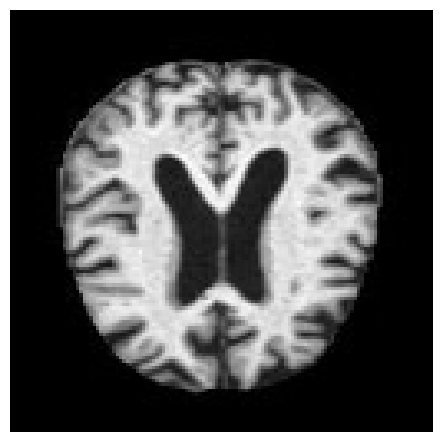

In [ ]:

dic = test_generator.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented/mild.jpg', target_size = (128,128,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model3.predict(img),axis=1)
y_pred_prob = model3.predict(img)
y_pred = np.round(np.max(y_pred_prob)*100,2)

print(y_pred, '% chances are there that the image is',idc[answer[0]])

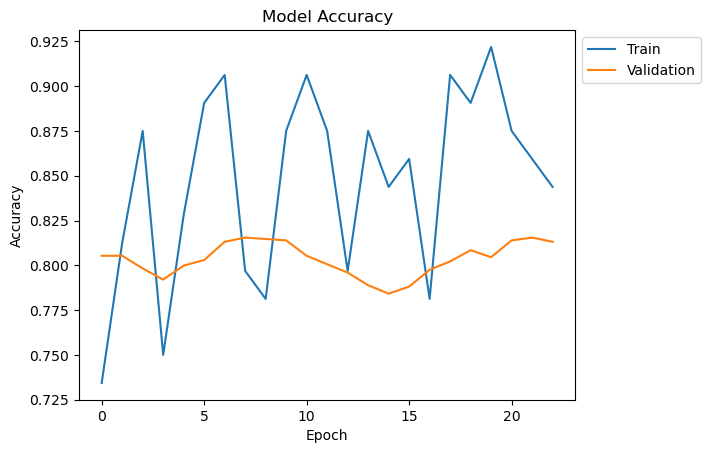

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

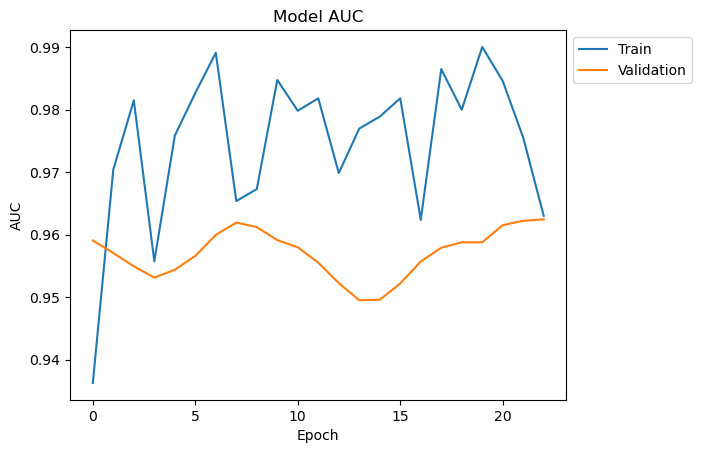

In [ ]:
plt.plot(history3.history['auc_1'])
plt.plot(history3.history['val_auc_1'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

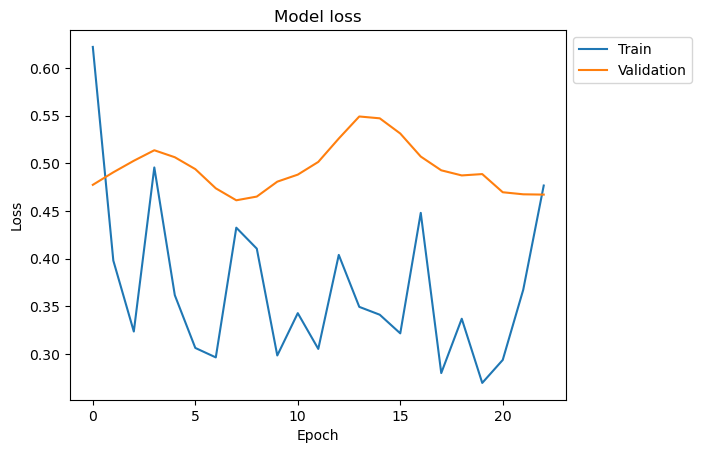

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [ ]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

21/21 [==============================] - 1s 66ms/step


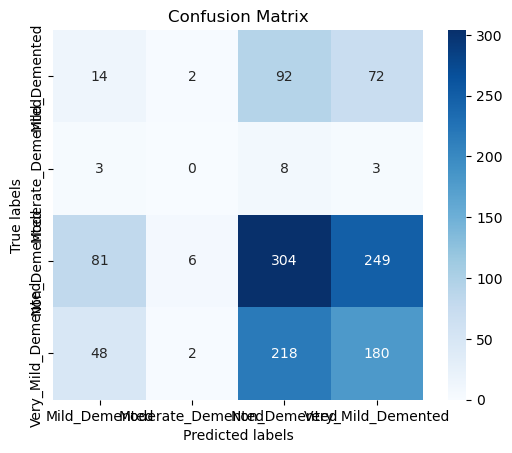

In [ ]:
#Confusion Matrix for vgg19

p = model.predict(test_generator)
predicted_lab = p.argmax(axis=-1)
true_lab = test_generator.classes
plot_confusion_matrix(true_lab, predicted_lab, test_generator.class_indices.keys(),filepath)


## DenseNet121

In [ ]:
base_model_4 = DenseNet121(input_shape=(128,128,3), 
                         include_top=False,
                         weights="imagenet")

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model_4.layers:
    layer.trainable=False

In [ ]:

model=Sequential()
model.add(base_model_4)

model.add(Dropout(0.5))
model.add(Flatten()
)
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512,kernel_initializer='he_uniform'))

model.add(Dense(4,activation='softmax'))

In [ ]:
models.append(model)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 4, 4, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 batch_normalization_5 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 dense_25 (Dense)            (None, 2048)              33556480  
                                                                 
 batch_normalization_6 (Batc  (None, 2048)             8192      
 hNormalization)                                      

In [ ]:
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs = epochs,
                    verbose=1)


Epoch 1/10


2023-06-02 00:07:01.994803: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60/60 [==============================] - 42s 412ms/step - loss: 1.8629 - accuracy: 0.4879 - auc: 0.7631 - precision: 0.4935 - recall: 0.4618 - val_loss: 2.4618 - val_accuracy: 0.5739 - val_auc: 0.8043 - val_precision: 0.5754 - val_recall: 0.5731
Epoch 2/10
60/60 [==============================] - 20s 325ms/step - loss: 1.3488 - accuracy: 0.5366 - auc: 0.8040 - precision: 0.5524 - recall: 0.5012 - val_loss: 1.5584 - val_accuracy: 0.5731 - val_auc: 0.8297 - val_precision: 0.5820 - val_recall: 0.5606
Epoch 3/10
60/60 [==============================] - 20s 334ms/step - loss: 1.0790 - accuracy: 0.5629 - auc: 0.8326 - precision: 0.5929 - recall: 0.5168 - val_loss: 1.0078 - val_accuracy: 0.6294 - val_auc: 0.8682 - val_precision: 0.6519 - val_recall: 0.5770
Epoch 4/10
60/60 [==============================] - 20s 340ms/step - loss: 0.9581 - accuracy: 0.6080 - auc: 0.8596 - precision: 0.6288 - recall: 0.5639 - val_loss: 0.8083 - val_accuracy: 0.6310 - val_auc: 0.8853 - val_precision: 0.6710 - va

In [ ]:
models.append("DenseNet121")
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 4, 4, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 batch_normalization_5 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 dense_25 (Dense)            (None, 2048)              33556480  
                                                                 
 batch_normalization_6 (Batc  (None, 2048)             8192      
 hNormalization)                                      

In [ ]:
result = model.evaluate(train_generator)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')

60/60 [==============================] - 18s 296ms/step - loss: 0.4794 - accuracy: 0.8221 - auc: 0.9653 - precision: 0.8644 - recall: 0.7570
Train Loss = 0.4794031083583832
Train Accuracy = 0.8220890760421753
Train AUC = 0.9653370976448059
Train Precision = 0.8643664717674255
Train Recall = 0.7569679617881775


In [ ]:
filepath = './DenseNet121_best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'auto' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='auto', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
history4 = model.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator)//32,
                        epochs = 20,callbacks = callback_list,
                        verbose = 1,batch_size=16)

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.5385 - accuracy: 0.7812 - auc: 0.9490 - precision: 0.8421 - recall: 0.7500
Epoch 1: val_accuracy improved from -inf to 0.73964, saving model to ./DenseNet121_best_weights.hdf5
1/1 [==============================] - 4s 4s/step - loss: 0.5385 - accuracy: 0.7812 - auc: 0.9490 - precision: 0.8421 - recall: 0.7500 - val_loss: 0.5772 - val_accuracy: 0.7396 - val_auc: 0.9380 - val_precision: 0.7747 - val_recall: 0.6990
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.6334 - accuracy: 0.7031 - auc: 0.9227 - precision: 0.7736 - recall: 0.6406
Epoch 2: val_accuracy did not improve from 0.73964
1/1 [==============================] - 2s 2s/step - loss: 0.6334 - accuracy: 0.7031 - auc: 0.9227 - precision: 0.7736 - recall: 0.6406 - val_loss: 0.5747 - val_accuracy: 0.7342 - val_auc: 0.9386 - val_precision: 0.7735 - val_recall: 0.6943
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.7640 - accurac

In [ ]:
result = model3.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)

21/21 [==============================] - 2s 94ms/step - loss: 0.4888 - accuracy: 0.7988 - auc: 0.9576 - precision: 0.8218 - recall: 0.7808
Test Loss = 0.4888087511062622
Test Accuracy = 0.798751950263977
Test AUC = 0.9576445817947388
Test Precision = 0.8218390941619873
Test Recall = 0.7808112502098083


1/1 [==============================] - 0s 35ms/step
93.01 % chances are there that the image is Mild_Demented


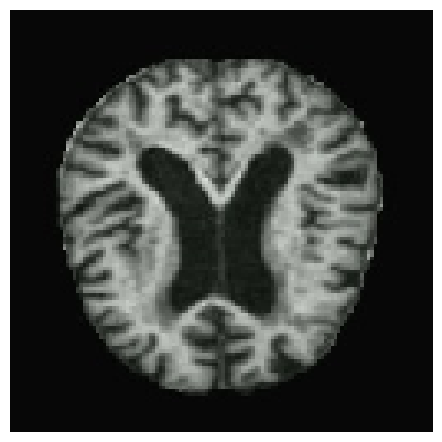

In [ ]:
dic = test_generator.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/00046ff7-0fae-4796-9a2b-2df47095bfe6.jpg', target_size = (128,128,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img),axis=1)
y_pred_prob = model.predict(img)
y_pred = np.round(np.max(y_pred_prob)*100,2)

print(y_pred, '% chances are there that the image is',idc[answer[0]])

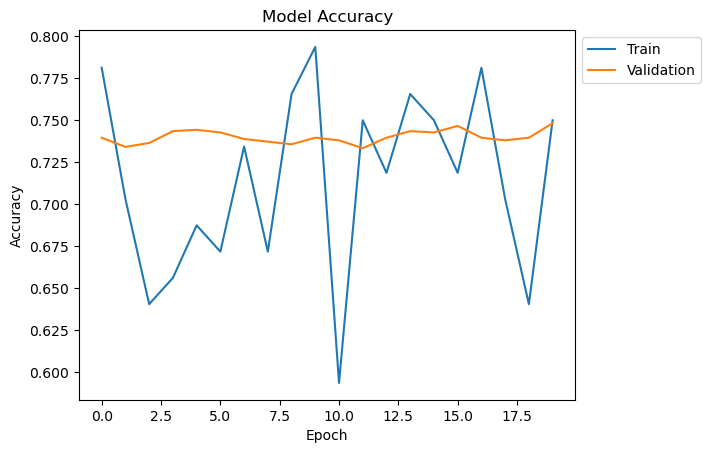

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

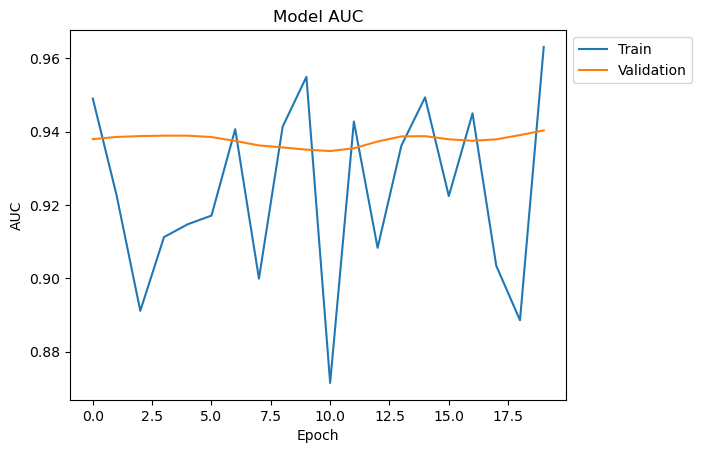

In [ ]:
plt.plot(history4.history['auc'])
plt.plot(history4.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

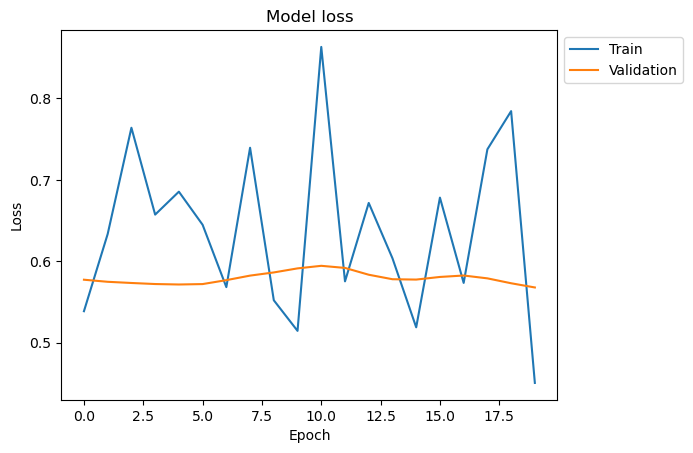

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [ ]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

21/21 [==============================] - 3s 71ms/step


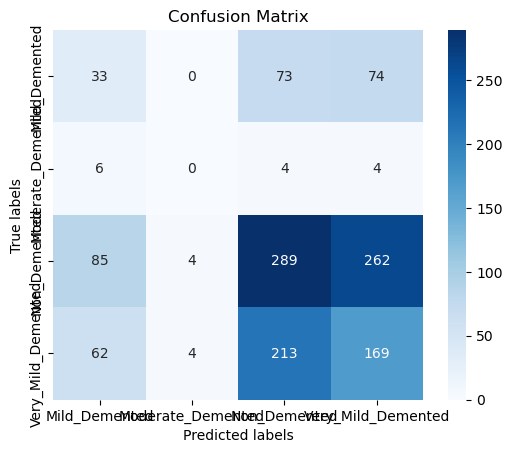

In [ ]:
#Confusion Matrix for densenet121 

p = model.predict(test_generator)
predicted_lab = p.argmax(axis=-1)
true_lab =test_generator.classes
plot_confusion_matrix(true_lab, predicted_lab, test_generator.class_indices.keys(),filepath)
